In [13]:
!pip install --upgrade nbformat
!pip install nbformat

In [23]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# ------------- choose a renderer -------------
# comment out the line you don't need
pio.renderers.default = "browser"        # opens in your browser
# pio.renderers.default = "svg"          # static SVG in many IDEs
# pio.renderers.default = "notebook"     # if Jupyter is working for you

# ------------- Collatz helpers -------------
def collatz_sequence(n: int) -> list[int]:
    seq = [n]
    while n != 1:
        n = n // 2 if n % 2 == 0 else 3 * n + 1
        seq.append(n)
    return seq

def local_extrema(seq: list[int]):
    """Return two lists: [(idx, val), …] for maxima and minima."""
    max_pts, min_pts = [], []
    for i in range(1, len(seq) - 1):
        if seq[i] > seq[i-1] and seq[i] > seq[i+1]:
            max_pts.append((i, seq[i]))
        elif seq[i] < seq[i-1] and seq[i] < seq[i+1]:
            min_pts.append((i, seq[i]))
    return max_pts, min_pts

# ------------- generate data -------------
orig_sequences = [collatz_sequence(n) for n in range(100, 0, -1)]
max_len = max(len(s) for s in orig_sequences)

fig = go.Figure()

for start, seq in zip(range(100, 0, -1), orig_sequences):
    shift = max_len - len(seq)              # how far to shift left
    x_seq = list(range(shift, shift + len(seq)))

    # main line
    fig.add_trace(
        go.Scatter(
            x=x_seq,
            y=seq,
            mode="lines",
            line=dict(width=1),
            opacity=0.5,
            name=f"{start}"
        )
    )

    # extrema markers
    maxima, minima = local_extrema(seq)
    if maxima:
        fig.add_trace(
            go.Scatter(
                x=[m[0] + shift for m in maxima],
                y=[m[1] for m in maxima],
                mode="markers",
                marker=dict(color="red", size=6),
                hovertemplate="Max<br>Step: %{x}<br>Value: %{y}<extra></extra>",
                showlegend=False
            )
        )
    if minima:
        fig.add_trace(
            go.Scatter(
                x=[m[0] + shift for m in minima],
                y=[m[1] for m in minima],
                mode="markers",
                marker=dict(color="blue", size=6),
                hovertemplate="Min<br>Step: %{x}<br>Value: %{y}<extra></extra>",
                showlegend=False
            )
        )

fig.update_layout(
    title="Collatz Sequences (100 → 1) – Right-aligned with local extrema",
    xaxis_title="Step (all sequences end at max length)",
    yaxis_title="Value",
    hovermode="closest",
    showlegend=False,
    height=700
)

# ---------- view or save ----------
fig.show()                       # or:
# fig.write_html("collatz.html", auto_open=True)


In [15]:
!python -c "import nbformat; print(nbformat.__version__)"



5.10.4


In [16]:
!python -c "import nbformat, inspect, sys; print(nbformat.__version__, nbformat.__file__)"
# Should print 5.x and a path in site-packages, NOT your project folder


5.10.4 /Users/ineshvytheswaran/miniconda3/envs/qis101/lib/python3.12/site-packages/nbformat/__init__.py


In [37]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# ---------------- renderer (pick one that works for you) -------------
pio.renderers.default = "browser"          # "svg" or "notebook" also OK

# ---------------- helpers --------------------------------------------
def collatz_sequence(n):
    s = [n]
    while n != 1:
        n = n // 2 if n % 2 == 0 else 3 * n + 1
        s.append(n)
    return s

def extrema(seq):
    max_pts, min_pts = [], []
    for i in range(1, len(seq) - 1):
        if seq[i] > seq[i-1] and seq[i] > seq[i+1]:
            max_pts.append((i, seq[i]))
        elif seq[i] < seq[i-1] and seq[i] < seq[i+1]:
            min_pts.append((i, seq[i]))
    return max_pts, min_pts

# ---------------- build figure ---------------------------------------
raw = [collatz_sequence(n) for n in range(10000, 0, -1)]
max_len = max(len(s) for s in raw)

fig   = go.Figure()
group = {}                     # start value -> list of trace indices

for start, seq in zip(range(100, 0, -1), raw):
    shift = max_len - len(seq)
    xs    = list(range(shift, shift + len(seq)))

    # main line+markers
    idx_line = len(fig.data)
    fig.add_trace(go.Scatter(
        x=xs, y=seq,
        mode="lines+markers",
        line=dict(width=1),
        marker=dict(size=4, opacity=0.55),
        name=f"{start}",
        hovertemplate="Step %{x}<br>Val %{y}<extra>start=%{text}</extra>",
        text=[start]*len(seq)
    ))

    # extrema markers (optional but nice)
    idx_extra = []
    mx, mn = extrema(seq)
    if mx:                                         # maxima
        idx_extra.append(len(fig.data))
        fig.add_trace(go.Scatter(
            x=[m[0]+shift for m in mx], y=[m[1] for m in mx],
            mode="markers",
            marker=dict(size=7, color="red"),
            hovertemplate="Max<br>Step %{x}<br>Val %{y}<extra></extra>",
            showlegend=False
        ))
    if mn:                                         # minima
        idx_extra.append(len(fig.data))
        fig.add_trace(go.Scatter(
            x=[m[0]+shift for m in mn], y=[m[1] for m in mn],
            mode="markers",
            marker=dict(size=7, color="blue"),
            hovertemplate="Min<br>Step %{x}<br>Val %{y}<extra></extra>",
            showlegend=False
        ))

    group[start] = [idx_line] + idx_extra

# ---------------- slider definition ----------------------------------
steps = []
all_trace_count = len(fig.data)
for upper in range(1, 101):                 # slider 1…100
    vis = [False] * all_trace_count
    for s in range(1, upper + 1):           # keep groups ≤ upper
        for idx in group[s]:
            vis[idx] = True
    steps.append(dict(
        method="update",
        label=f"≤ {upper}",
        args=[{"visible": vis},
              {"title": f"Collatz sequences – starts 1 → {upper}"}]
    ))

fig.update_layout(
    sliders=[dict(
        active=99,
        currentvalue=dict(prefix="Showing starts ≤ "),
        pad=dict(t=40),
        steps=steps
    )],
    title="Collatz sequences – starts 1 → 100 (drag slider)",
    xaxis_title="Step (aligned so every sequence ends at 1 on the right)",
    yaxis_title="Value",
    hovermode="closest",
    height=700,
    showlegend=False
)

fig.show()
# or: fig.write_html("collatz_slider.html", auto_open=True)


In [35]:
import plotly.graph_objects as go
import plotly.io as pio

# ---- pick a renderer you like ----
pio.renderers.default = "browser"          # "svg" / "notebook" also OK

# ---- Collatz + extrema helpers ----
def collatz_sequence(n):
    seq = [n]
    while n != 1:
        n = n // 2 if n % 2 == 0 else 3 * n + 1
        seq.append(n)
    return seq

def extrema(seq):
    mx, mn = [], []
    for i in range(1, len(seq)-1):
        if seq[i] > seq[i-1] and seq[i] > seq[i+1]:
            mx.append((i, seq[i]))          # (step, value)
        elif seq[i] < seq[i-1] and seq[i] < seq[i+1]:
            mn.append((i, seq[i]))
    return mx, mn

# ---- generate extrema for starts 100 → 1 ----
orig   = [collatz_sequence(n) for n in range(100, 0, -1)]
maxlen = max(len(s) for s in orig)

xs_max, ys_max, text_max = [], [], []
xs_min, ys_min, text_min = [], [], []

for start, seq in zip(range(10000, 0, -1), orig):
    shift = maxlen - len(seq)           # right-align
    mx, mn = extrema(seq)
    for step, val in mx:
        xs_max.append(step + shift)
        ys_max.append(val)
        text_max.append(start)
    for step, val in mn:
        xs_min.append(step + shift)
        ys_min.append(val)
        text_min.append(start)

# ---- build the figure ----
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=xs_max, y=ys_max,
    mode="markers",
    marker=dict(color="red", size=7),
    name="Local maxima",
    hovertemplate="Max<br>Start %{text}<br>Step %{x}<br>Value %{y}<extra></extra>",
    text=text_max
))

fig.add_trace(go.Scatter(
    x=xs_min, y=ys_min,
    mode="markers",
    marker=dict(color="blue", size=7),
    name="Local minima",
    hovertemplate="Min<br>Start %{text}<br>Step %{x}<br>Value %{y}<extra></extra>",
    text=text_min
))

fig.update_layout(
    title="Collatz sequences (100 → 1) — only local minima & maxima",
    xaxis_title="Step (sequences right-aligned)",
    yaxis_title="Value",
    hovermode="closest",
    height=650
)

fig.show()
# Or save instead of show:
# fig.write_html("collatz_extrema_only.html", auto_open=True)


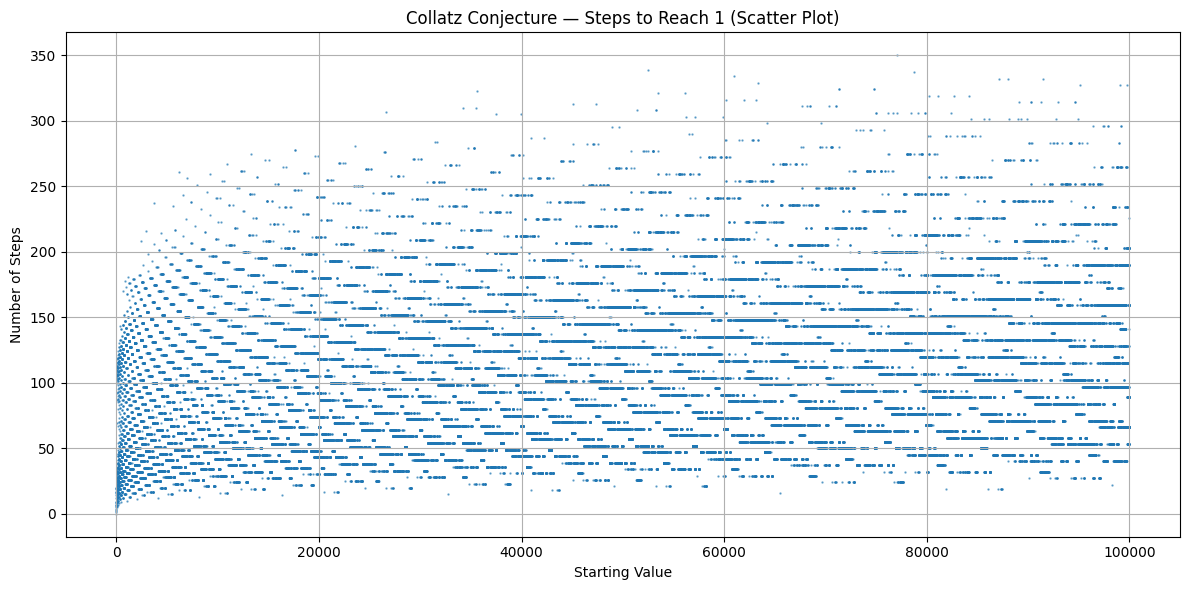

In [39]:
import matplotlib.pyplot as plt

def collatz_steps(n):
    steps = 0
    while n != 1:
        n = n // 2 if n % 2 == 0 else 3 * n + 1
        steps += 1
    return steps

# Generate data for 1 to 100,000
N = 100_000
x_vals = list(range(1, N + 1))
y_vals = [collatz_steps(n) for n in x_vals]

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x_vals, y_vals, s=0.5, alpha=0.6)
plt.title("Collatz Conjecture — Steps to Reach 1 (Scatter Plot)")
plt.xlabel("Starting Value")
plt.ylabel("Number of Steps")
plt.grid(True)
plt.tight_layout()
plt.show()
